# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [134]:
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001

In [135]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time
import random
random.seed = 17

# Generate a random softmax weight matrix and use it to compute the loss.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.335597
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [136]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.242477 analytic: -1.242477, relative error: 1.129796e-08
numerical: -0.872214 analytic: -0.872214, relative error: 2.581137e-08
numerical: -1.747568 analytic: -1.747568, relative error: 1.930169e-09
numerical: -0.258495 analytic: -0.258495, relative error: 7.451779e-08
numerical: 0.230520 analytic: 0.230521, relative error: 2.228269e-07
numerical: 2.525056 analytic: 2.525056, relative error: 1.039303e-08
numerical: 0.669212 analytic: 0.669212, relative error: 5.097189e-08
numerical: 0.611629 analytic: 0.611629, relative error: 4.013097e-08
numerical: 0.353985 analytic: 0.353985, relative error: 2.836468e-08
numerical: 0.834249 analytic: 0.834249, relative error: 9.805061e-08
numerical: -0.602461 analytic: -0.602461, relative error: 5.285553e-08
numerical: -0.771207 analytic: -0.771207, relative error: 4.311038e-08
numerical: -2.548515 analytic: -2.548515, relative error: 2.216729e-08
numerical: 3.005058 analytic: 3.005058, relative error: 1.893761e-08
numerical: 3.114313 

In [165]:
X = X_dev.copy()
y = y_dev.copy()
loss = 0.0
dW = np.zeros_like(W)
##############################################################
num_train = X.shape[0]
num_classes = W.shape[1]

scores = X.dot(W)

scores.shape


# loss += -np.log(sigma)


# loss /= num_train
# dW /= num_train

(500, 10)

In [181]:
sigma = np.exp(scores) / np.reshape(np.sum(np.exp(scores), axis=1), (num_train, -1))

np.sum(-np.log(sigma[range(y.shape[0]), y])) / num_train

2.3355974901668146

In [182]:
np.mean(-np.log(sigma[range(y.shape[0]), y])) 

2.3355974901668146

In [184]:
X.shape, sigma.shape

((500, 3073), (500, 10))

In [186]:
np.transpose(X).dot(sigma)

array([[ 231.04519801,  220.40015578, -762.5434223 , ..., -220.2849514 ,
         541.46469743, -240.3035524 ],
       [ 167.51798532,  220.78463018, -756.81035684, ..., -389.22532003,
         438.26794106,  -89.19130361],
       [ -73.65137634,  261.35487652, -821.12279555, ..., -624.84468803,
         390.00621642,   25.79477555],
       ...,
       [ 271.89113431,  261.59287662,  112.8921388 , ..., -271.83153383,
          24.85112232, -222.56919374],
       [   8.10197825,  284.96317924,   57.83975136, ..., -434.86606565,
          21.19106013, -161.75770683],
       [  49.65656895,   47.93804949,   51.7911354 , ...,   51.13135092,
          50.97350782,   48.72672448]])

In [187]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.335597e+00 computed in 0.232209s
vectorized loss: 2.335597e+00 computed in 0.013522s
Loss difference: 0.000000
Gradient difference: 0.000000


In [200]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
from tqdm import tqdm_notebook

results = {}
best_val = -1
best_softmax = None
learning_rates = np.linspace(1e-8, 5e-6, 20) 
regularization_strengths = np.linspace(2.5e2, 5e3, 20)
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
softmax = Softmax()
for lr in tqdm_notebook(learning_rates, total = len(learning_rates),  mininterval=1):
    for reg in regularization_strengths:
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=100, verbose=False)
        y_train_acc = np.mean(y_train == softmax.predict(X_train))
        y_val_acc = np.mean(y_val == softmax.predict(X_val))
        results[(lr, reg)] = (y_train_acc, y_val_acc)
        if y_val_acc > best_val:
            best_val = y_val_acc
            best_softmax = softmax 
            best_lr = lr
            best_reg = reg

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 1.000000e-08 reg 2.500000e+02 train accuracy: 0.101041 val accuracy: 0.123000
lr 1.000000e-08 reg 5.000000e+02 train accuracy: 0.108306 val accuracy: 0.134000
lr 1.000000e-08 reg 7.500000e+02 train accuracy: 0.115265 val accuracy: 0.140000
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.120429 val accuracy: 0.151000
lr 1.000000e-08 reg 1.250000e+03 train accuracy: 0.125306 val accuracy: 0.154000
lr 1.000000e-08 reg 1.500000e+03 train accuracy: 0.129490 val accuracy: 0.158000
lr 1.000000e-08 reg 1.750000e+03 train accuracy: 0.133469 val accuracy: 0.157000
lr 1.000000e-08 reg 2.000000e+03 train accuracy: 0.137633 val accuracy: 0.162000
lr 1.000000e-08 reg 2.250000e+03 train accuracy: 0.142163 val accuracy: 0.168000
lr 1.000000e-08 reg 2.500000e+03 train accuracy: 0.145490 val accuracy: 0.173000
lr 1.000000e-08 reg 2.750000e+03 train accuracy: 0.149469 val accuracy: 0.175000
lr 1.000000e-08 reg 3.000000e+03 train accuracy: 0.152653 val accuracy: 0.180000
lr 1.000000e-08 reg 3.25000

In [197]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.318000


In [199]:
best_lr, best_reg

(4.212105263157895e-06, 750.0)

**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

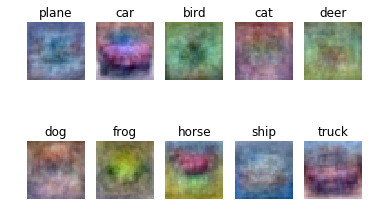

In [198]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])